In [1]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.preprocessing import image
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import merge,Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, Dense, Conv2D, MaxPooling2D,Conv2DTranspose, \
    UpSampling2D, Activation, LeakyReLU, Flatten, Dropout, GaussianNoise
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
import glob
import tensorflow

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
import pickle
import os 

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# %cd '/content/drive/Team Drives/ECE228/tests'

### Load data

In [2]:
def load():
    import numpy as np
    import pickle
    import os 
    path = os.getcwd()
    path = path + '/'
    data = []
    labels = []
    directories = []
    for out_files in os.listdir():
        
        if out_files == 'Gesture_Recognition.ipynb':
            continue
        if not out_files.startswith('.'):
            print('Reading file ',out_files,'...')
            if (out_files == 'output_lb.p'):
                read_file =  path + out_files
                labels = pickle.load( open( read_file, "rb" ) )
                continue
            directories.append(out_files)
            directories.sort(key=lambda x: int(x[10:12]) if len(x)==14 else int(x[10:11]))
    for i in directories:
        print(i,out_files,'...')
        read_file =  path  + i
        data_t = pickle.load( open( read_file, "rb" ) )    
        data.append(data_t)
        
    directories.sort()
 
    ln = len(data)
    im_ln = len(data[0][0])
    M     = len(data[0])
    label = np.array(labels[0:ln*M])
    dataa = np.zeros((M*ln,im_ln,im_ln,1))
    l = 0
    for i in data:
       for j in i:
            dataa[l,:,:,0] = j
            l = l +1
    return   dataa, label    



dataa, lb = load()

data = np.array(dataa)

data = data.reshape(-1, 120,120, 1)
labels = np.array(lb)


Reading file  output_lb.p ...
Reading file  output_im_2.p ...
Reading file  output_im_3.p ...
Reading file  output_im_1.p ...
Reading file  output_im_0.p ...
output_im_0.p .ipynb_checkpoints ...
output_im_1.p .ipynb_checkpoints ...
output_im_2.p .ipynb_checkpoints ...
output_im_3.p .ipynb_checkpoints ...


In [3]:
print(data.shape)
print(labels.shape)

(20000, 120, 120, 1)
(20000,)


In [ ]:
# data = np.random.rand(40000,120,120,1)
# labelss = np.hstack((labels,labels))
# labels = np.hstack((labelss,labelss))
# labels = labels.T
# #labelss = np.random.randint(low=0,high=9, size=20000)
# print(data.shape)
# print(labels.shape)
# #print(data)

In [4]:
print(data.shape)
data, labels = shuffle(data, labels, random_state=0)

(20000, 120, 120, 1)


In [5]:
# train_data = data[0:6000,:,:,:]
# train_labels = labels[0:6000]

# val_data = data[6000:8000,:,:,:]
# val_labels = labels[6000:8000]

# test_data = data[8000:,:,:,:]
# test_labels = labels[8000:]

train_data = data[0:16000,:,:,:]
train_labels = labels[0:16000]

val_data = data[16000:18000,:,:,:]
val_labels = labels[16000:18000]

test_data = data[18000:,:,:,:]
test_labels = labels[18000:]

In [ ]:
# def gaussian_noise(img, sigma):
#     mean = 0
#     noisy_img = img + 0.5*np.random.normal(mean,sigma,img.shape)
#     return noisy_img

# train_data[0:8000,:,:,:] = gaussian_noise(train_data[0:8000,:,:,:], 0.1)
# val_data[0:8000,:,:,:] = gaussian_noise(val_data[0:1000,:,:,:], 0.1)
# test_data[0:8000,:,:,:] = gaussian_noise(test_data[0:1000,:,:,:], 0.1)


In [6]:
len(test_data)

2000

In [7]:
print(train_data.shape)
print(test_data.shape)

(16000, 120, 120, 1)
(2000, 120, 120, 1)


In [8]:
print(train_labels.shape)
print(val_labels.shape)

(16000,)
(2000,)


### Preprocess

In [9]:
# train_data = train_data / np.max(train_data)
# val_data = val_data / np.max(val_data)
# test_data = test_data / np.max(test_data)

In [10]:
# train_X, valid_X, train_y, valid_y = train_test_split(train_data, \
#                                                       train_labels, test_size=0.2, random_state=5)
#data_train, label_train, data_test, label_test = train_test_split(train_data, \
                                                     # train_labels[0:5000], test_size=0.2, random_state=13)

In [11]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(train_labels)
encoded_labels = encoder.transform(train_labels)
train_labels_onehot = np_utils.to_categorical(encoded_labels)

encoder.fit(val_labels)
encoded_labels = encoder.transform(val_labels)
val_labels_onehot = np_utils.to_categorical(encoded_labels)

encoder.fit(test_labels)
encoded_labels = encoder.transform(test_labels)
test_labels_onehot = np_utils.to_categorical(encoded_labels)


### Architecture

In [12]:
def CNN():
    input_img = Input(shape=(120, 120, 1))
    x = Conv2D(128, (3, 3), activation='relu', padding='same', dilation_rate=(2,2))(input_img)
    x = GaussianNoise(0.01)(x)
    x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.3)(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same', dilation_rate=(2,2))(x)
   # x = GaussianNoise(0.001)(x)
    x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.3)(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same', dilation_rate=(2,2))(x)
#     x = GaussianNoise(0.1)(x)
    x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.3)(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
  #  x = GaussianNoise(0.01)(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)
    return Model(input_img, output)


batch_size = 64
epochs = 10
num_classes = 10

In [13]:
CNN = CNN()
CNN.compile(loss='categorical_crossentropy',  optimizer = RMSprop(), metrics=['accuracy'])


In [14]:
CNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 120, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 128)     1280      
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 120, 120, 128)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 120, 120, 128)     512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        73792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 60, 64)        256       
__________

### Train

In [15]:
CNN_train = CNN.fit(train_data, train_labels_onehot, batch_size=batch_size,epochs=epochs,\
                                    verbose=1,validation_data=(val_data, val_labels_onehot))

Train on 16000 samples, validate on 2000 samples
Epoch 1/10
16000/16000 [==============================] - 36s 2ms/step - loss: 0.6155 - acc: 0.8337 - val_loss: 3.2596 - val_acc: 0.7075
Epoch 2/10
16000/16000 [==============================] - 34s 2ms/step - loss: 0.0558 - acc: 0.9820 - val_loss: 0.8791 - val_acc: 0.8605
Epoch 3/10
16000/16000 [==============================] - 33s 2ms/step - loss: 0.0375 - acc: 0.9909 - val_loss: 0.4494 - val_acc: 0.9265
Epoch 4/10
16000/16000 [==============================] - 33s 2ms/step - loss: 0.0276 - acc: 0.9929 - val_loss: 12.0792 - val_acc: 0.1970
Epoch 5/10
16000/16000 [==============================] - 33s 2ms/step - loss: 0.0188 - acc: 0.9957 - val_loss: 6.9656 - val_acc: 0.4560
Epoch 6/10
16000/16000 [==============================] - 33s 2ms/step - loss: 0.0146 - acc: 0.9964 - val_loss: 11.9709 - val_acc: 0.2130
Epoch 7/10
16000/16000 [==============================] - 33s 2ms/step - loss: 0.0107 - acc: 0.9975 - val_loss: 13.4081 - val_a

In [ ]:
# CNN.save('my_CNN.h5')

### Results

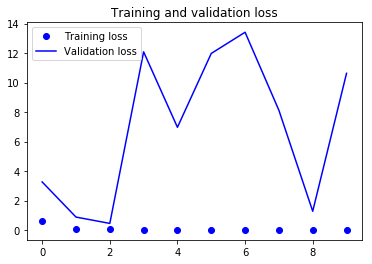

In [16]:
loss = CNN_train.history['loss']
val_loss = CNN_train.history['val_loss']
epochs = range(10)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Predict and Evaluate on Test set

In [17]:
print(test_labels_onehot.shape)
print(len(test_data))

(2000, 10)
2000


In [18]:
loss, acc = CNN.evaluate(test_data, test_labels_onehot, batch_size=batch_size, verbose=0)

In [19]:
print('Test loss:', loss)
print('Test accuracy:', acc)

Test loss: 10.824957443237304
Test accuracy: 0.2845


In [35]:
predicted_classes = CNN.predict(test_data)

In [36]:
print(predicted_classes.shape)
predicted = predicted_classes.argmax(axis=1)

(2000, 10)


In [37]:
print("predicted:", predicted)
predicted.shape
#print("ground truth:",(test_labels).astype(int).T[0])

predicted: [1 9 3 ... 3 3 3]


(2000,)

In [38]:
correct = np.where(predicted==test_labels)[0]
print(len(correct))

569


Found 569 correct labels


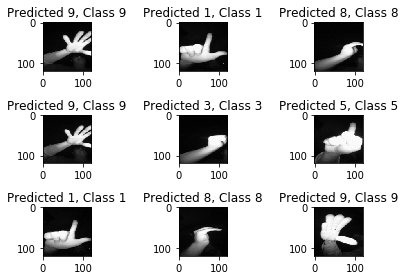

In [39]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
predicted_classes.shape, test_labels_onehot.shape
#((10000,), (10000,))
#correct = np.where(predicted_classes==test_labels_onehot)[0]
print('Found %d correct labels' %len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[correct].reshape(120,120), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_labels[correct]))
    plt.tight_layout()

Found 1431 incorrect labels


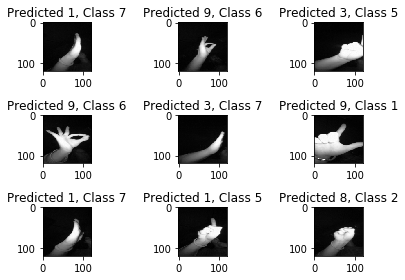

In [42]:
incorrect = np.where(predicted_classes!=test_labels)[0]
print('Found %d incorrect labels' % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[incorrect].reshape(120,120), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_labels[incorrect]))
    plt.tight_layout()

In [50]:
import sklearn.metrics as metrics
# label_true = label_test
# label_pred = prediction.argmax(axis=1) + 1 # increment because our classes start at 1 - 5
confusion_matrix = metrics.confusion_matrix(y_true=test_labels, y_pred=predicted_classes)  # shape=(12, 12)

Text(0.5,1,'Normalized Confusion Matrix')

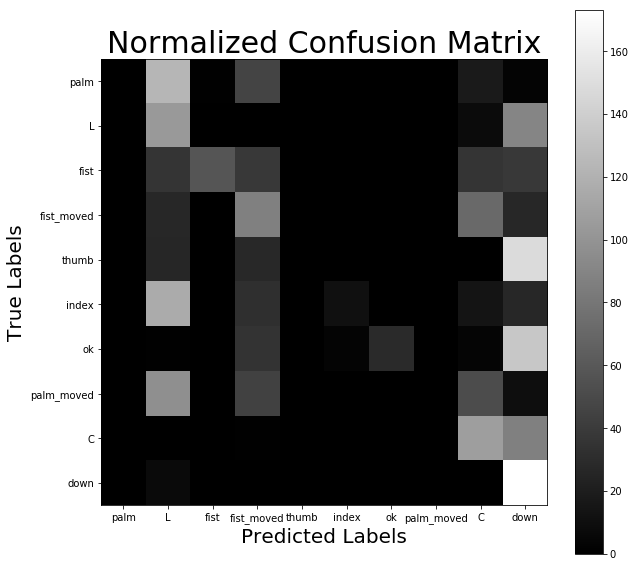

In [60]:
# classes = { 'palm'       : 0,
#             'l'          : 1,
#             'fist'       : 2,
#             'fist_moved' : 3,
#             'thumb'      : 4,
#             'index'      : 5,
#             'ok'         : 6,
#             'palm_moved' : 7,
#             'c'          : 8,
#             'down'       : 9
#               }
classes = {0: 'palm',
           1: 'L',  
           2: 'fist',     
           3: 'fist_moved', 
           4: 'thumb',      
           5: 'index',     
           6: 'ok',        
           7: 'palm_moved', 
           8: 'C',         
           9: 'down'  
              }
fig = plt.figure(figsize=(10, 10))
plt.imshow(confusion_matrix, cmap='gray')
plt.xticks(np.arange(10), list(classes.values()))
plt.xlabel("Predicted Labels", fontsize=20)
plt.yticks(np.arange(10), list(classes.values()))
plt.ylabel("True Labels", fontsize=20)
plt.colorbar()
plt.title("Normalized Confusion Matrix", fontsize=30)

### Classification Report

In [43]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_labels, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00       191
     Class 1       0.19      0.51      0.28       202
     Class 2       0.98      0.28      0.44       207
     Class 3       0.28      0.41      0.33       213
     Class 4       0.00      0.00      0.00       202
     Class 5       0.79      0.06      0.10       200
     Class 6       1.00      0.14      0.25       207
     Class 7       0.00      0.00      0.00       203
     Class 8       0.34      0.55      0.42       195
     Class 9       0.23      0.96      0.38       180

   micro avg       0.28      0.28      0.28      2000
   macro avg       0.38      0.29      0.22      2000
weighted avg       0.39      0.28      0.22      2000



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
